# Analyze SARS-CoV-2 3D Protein Structures
[Work in progress]

This notebook analyzes available 3D protein structures for the SAR-CoV-2 virus in the [Protein Data Bank](https://www.wwpdb.org/).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib
import seaborn as sns
from py2neo import Graph

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

#### Connect to COVID-19-Community Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

### Number of PDB Structures by Protein

In [4]:
reference_genome = 'ncbiprotein:NC_045512' # Genbank reference sequence

In [5]:
query = """
MATCH (r:Strain{id: $reference_genome})-[:HAS]->(g:Gene)-[:ENCODES]->(p:Protein)
      -[:HAS_TERTIARY_STRUCTURE]->(:Chain)-[:IS_PART_OF_STRUCTURE]->(s:Structure)
WHERE (g.end - g.start) < 10000 // exclude polyproteins
RETURN r.id AS referenceGenome, r.name AS strain, g.name AS gene, g.start AS geneStart, g.end AS geneEnd, 
       p.name AS protein, p.accession AS accession, p.proId AS uniprotChain, count(s) AS structures
ORDER BY geneStart, accession, geneEnd DESC
"""
pdbs = graph.run(query, reference_genome=reference_genome).to_data_frame()
pdbs.head(1000)

,referenceGenome,strain,gene,geneStart,geneEnd,protein,accession,uniprotChain,structures
0,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,266,805,Host translation inhibitor nsp1,uniprot:P0DTD1,uniprot.chain:PRO_0000449619,11
1,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,2720,8554,Non-structural protein 3,uniprot:P0DTD1,uniprot.chain:PRO_0000449621,59
2,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,10055,10972,3C-like proteinase,uniprot:P0DTD1,uniprot.chain:PRO_0000449623,205
3,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,11843,12091,Non-structural protein 7,uniprot:P0DTD1,uniprot.chain:PRO_0000449625,23
4,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,12092,12685,Non-structural protein 8,uniprot:P0DTD1,uniprot.chain:PRO_0000449626,33
5,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,12686,13024,Non-structural protein 9,uniprot:P0DTD1,uniprot.chain:PRO_0000449627,7
6,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,13025,13441,Non-structural protein 10,uniprot:P0DTD1,uniprot.chain:PRO_0000449628,21
7,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,13442,16236,RNA-directed RNA polymerase,uniprot:P0DTD1,uniprot.chain:PRO_0000449629,11
8,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,16237,18039,Helicase,uniprot:P0DTD1,uniprot.chain:PRO_0000449630,4
9,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,19621,20658,Uridylate-specific endoribonuclease,uniprot:P0DTD1,uniprot.chain:PRO_0000449632,14


### Number of structures by protein and structure determination method

In [6]:
query = """
MATCH (r:Strain{id: $reference_genome})-[:HAS]->(g:Gene)-[:ENCODES]->(p:Protein)
      -[:HAS_TERTIARY_STRUCTURE]->(:Chain)-[:IS_PART_OF_STRUCTURE]->(s:Structure)
WHERE (g.end - g.start) < 10000 // exclude polyproteins
RETURN r.id AS referenceGenome, r.name AS strain, g.name AS gene, g.start AS geneStart, g.end AS geneEnd, 
       p.name AS protein, p.accession AS accession, p.proId AS uniprotChain, s.method AS method, count(s.method) AS structures
ORDER BY geneStart, accession, geneEnd DESC
"""
pdbs = graph.run(query, reference_genome=reference_genome).to_data_frame()
pdbs.head(1000)

,referenceGenome,strain,gene,geneStart,geneEnd,protein,accession,uniprotChain,method,structures
0,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,266,805,Host translation inhibitor nsp1,uniprot:P0DTD1,uniprot.chain:PRO_0000449619,ELECTRON MICROSCOPY,11
1,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,2720,8554,Non-structural protein 3,uniprot:P0DTD1,uniprot.chain:PRO_0000449621,X-RAY DIFFRACTION,59
2,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,10055,10972,3C-like proteinase,uniprot:P0DTD1,uniprot.chain:PRO_0000449623,X-RAY DIFFRACTION,205
3,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,11843,12091,Non-structural protein 7,uniprot:P0DTD1,uniprot.chain:PRO_0000449625,ELECTRON MICROSCOPY,11
4,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,11843,12091,Non-structural protein 7,uniprot:P0DTD1,uniprot.chain:PRO_0000449625,X-RAY DIFFRACTION,12
5,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,12092,12685,Non-structural protein 8,uniprot:P0DTD1,uniprot.chain:PRO_0000449626,ELECTRON MICROSCOPY,21
6,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,12092,12685,Non-structural protein 8,uniprot:P0DTD1,uniprot.chain:PRO_0000449626,X-RAY DIFFRACTION,12
7,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,12686,13024,Non-structural protein 9,uniprot:P0DTD1,uniprot.chain:PRO_0000449627,X-RAY DIFFRACTION,7
8,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,13025,13441,Non-structural protein 10,uniprot:P0DTD1,uniprot.chain:PRO_0000449628,X-RAY DIFFRACTION,21
9,ncbiprotein:NC_045512,Wuhan-Hu-1,ORF1ab,13442,16236,RNA-directed RNA polymerase,uniprot:P0DTD1,uniprot.chain:PRO_0000449629,ELECTRON MICROSCOPY,11


### Number of structures by protein and release date

In [7]:
query = """
MATCH (r:Strain{id: $reference_genome})-[:HAS]->(g:Gene)-[:ENCODES]->(p:Protein)
      -[:HAS_TERTIARY_STRUCTURE]->(:Chain)-[:IS_PART_OF_STRUCTURE]->(s:Structure)
WHERE (g.end - g.start) < 10000 // exclude polyproteins
RETURN p.name AS protein, s.releaseDate AS releaseDate, count(s.releaseDate) AS structures
ORDER BY protein, releaseDate
"""
pdbs_by_date = graph.run(query, reference_genome=reference_genome).to_data_frame()

In [8]:
pdbs_by_date['cummulativeStructures'] = pdbs_by_date.groupby(['protein'])['structures'].cumsum()

In [9]:
pdbs_by_date.head()

,protein,releaseDate,structures,cummulativeStructures
0,2'-O-methyltransferase,2020-03-17,1,1
1,2'-O-methyltransferase,2020-03-24,2,3
2,2'-O-methyltransferase,2020-04-21,2,5
3,2'-O-methyltransferase,2020-04-28,2,7
4,2'-O-methyltransferase,2020-05-05,2,9


In [10]:
df_date = pd.DataFrame(pdbs_by_date.pivot(index='releaseDate', columns='protein', values='cummulativeStructures').to_records())

Convert neo4j date object to datetime

In [11]:
df_date['releaseDate'] = df_date['releaseDate'].astype(str)
df_date['releaseDate'] = pd.to_datetime(df_date['releaseDate'], infer_datetime_format=False) 

Fill gaps by value from previous day

In [12]:
df_date.fillna(method='ffill', inplace=True)
df_date['releaseDate'] = pd.to_datetime(df_date['releaseDate'], infer_datetime_format=False) 

In [13]:
df_date.head(1000)

,releaseDate,2'-O-methyltransferase,3C-like proteinase,Helicase,Host translation inhibitor nsp1,Non-structural protein 10,Non-structural protein 3,Non-structural protein 7,Non-structural protein 8,Non-structural protein 9,Nucleoprotein,ORF3a protein,ORF7a protein,ORF8 protein,RNA-directed RNA polymerase,Spike glycoprotein,Uridylate-specific endoribonuclease
0,2020-02-04,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-25,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN
2,2020-03-03,NaN,5.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,2.0
3,2020-03-10,NaN,14.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,23.0,4.0
4,2020-03-17,1.0,14.0,NaN,NaN,1.0,4.0,NaN,NaN,2.0,8.0,NaN,NaN,NaN,NaN,25.0,4.0
5,2020-03-24,3.0,84.0,NaN,NaN,4.0,6.0,NaN,NaN,2.0,8.0,NaN,NaN,NaN,NaN,26.0,4.0
6,2020-03-31,3.0,85.0,NaN,NaN,4.0,9.0,1.0,2.0,2.0,8.0,NaN,NaN,NaN,1.0,26.0,4.0
7,2020-04-07,3.0,85.0,NaN,NaN,4.0,9.0,2.0,4.0,3.0,9.0,NaN,NaN,NaN,2.0,26.0,4.0
8,2020-04-14,3.0,106.0,NaN,NaN,4.0,11.0,2.0,4.0,3.0,9.0,NaN,NaN,NaN,2.0,28.0,4.0
9,2020-04-21,5.0,107.0,NaN,NaN,6.0,11.0,5.0,8.0,3.0,15.0,NaN,NaN,NaN,4.0,28.0,4.0


#### TODO: use scatter plot instead of line plot since release dates are not continuous

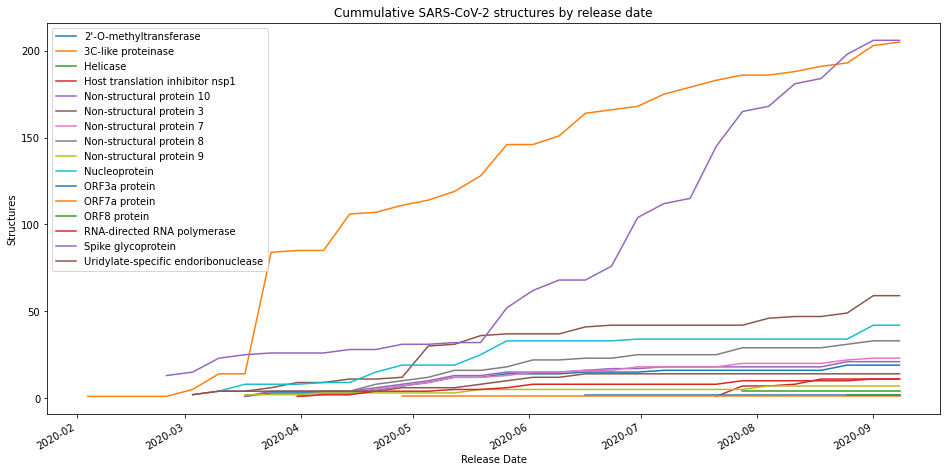

In [14]:
import matplotlib.dates as mdates
ax = df_date.plot(figsize=(16, 8), x='releaseDate', title='Cummulative SARS-CoV-2 structures by release date');
ax.set_xlabel('Release Date');
ax.set_ylabel('Structures');
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

### Distribution of resolution by protein

In [15]:
query = """
MATCH (r:Strain{id: $reference_genome})-[:HAS]->(g:Gene)-[:ENCODES]->(p:Protein)
      -[:HAS_TERTIARY_STRUCTURE]->(:Chain)-[:IS_PART_OF_STRUCTURE]->(s:Structure)
WHERE (g.end - g.start) < 10000 AND s.method IN ['X-RAY DIFFRACTION', 'ELECTRON MICROSCOPY'] // exclude polyproteins 
RETURN p.name AS protein, s.resolution AS resolution, s.name, s.method
ORDER BY protein, resolution
"""
pdbs_by_res = graph.run(query, reference_genome=reference_genome).to_data_frame()

In [16]:
df_res = pd.DataFrame(pdbs_by_res.pivot(columns='protein', values='resolution').to_records())

In [17]:
df_res.drop_duplicates(inplace=True)

In [18]:
df_res.drop('index', axis=1, inplace=True)

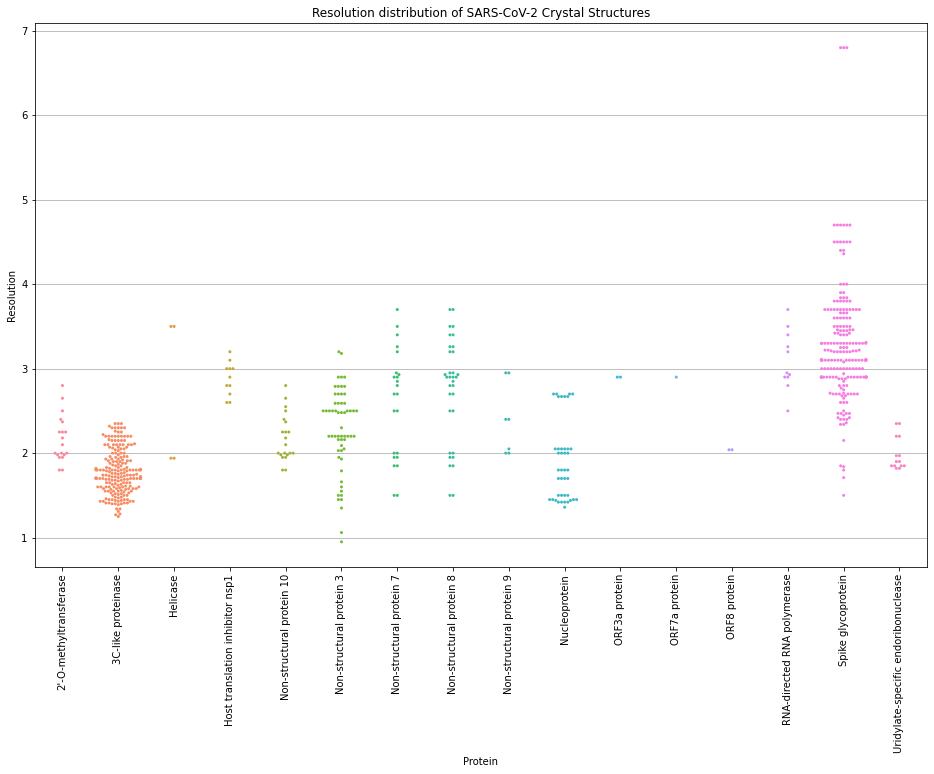

In [37]:
fig, axes = plt.subplots(figsize=(16, 10))
#sns.violinplot(data=df_res, scale='width', ax = axes)
sns.swarmplot(data=df_res, size=3, ax = axes)


axes.set_title('Resolution distribution of SARS-CoV-2 Crystal Structures')
axes.yaxis.grid(True)
axes.set_xlabel('Protein')
axes.set_ylabel('Resolution')

plt.xticks(rotation=90)
plt.show()